In [68]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

os.getcwd()

'/Users/blake_hartung/Documents/FALL 2022/ocean-depth-characterization/preliminary_models'

In [69]:
# import dataframe
df_norm_piv = pd.read_csv('../data/final_norm_set_10.csv')
cluster_indeces = ['HCB', 'PDCM', 'EQ', 'LCB', 'AR', 'SDCM']

# split data
full_train = df_norm_piv[df_norm_piv.train == 1]
full_test = df_norm_piv[df_norm_piv.train == 0]

# narrow down the features we want
X_train = full_train[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
X_test = full_test[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
# get labels
label_bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Y_train = full_train[['norm_' + str(i) for i in label_bins]]
Y_test = full_test[['norm_' + str(i) for i in label_bins]]
input_dim = X_train.shape[1]
output_dim = Y_train.shape[1]

#scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [70]:
'''
# set up the model
nn_model = Sequential()

nn_model.add(Dense(256, input_dim=input_dim, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(64, activation='relu'))
nn_model.add(Dropout(0.2))
nn_model.add(Dense(output_dim))

nn_model.compile(loss='mse', optimizer='adam')

# fit the model
nn_history = nn_model.fit(X_train, Y_train, epochs=10, batch_size=24, verbose=1)

# check our MSE on the 4 prediction points
preds = nn_model.predict(X_test)
train_pred = nn_model.predict(X_train)
'''
# or try xgb
xgb_preds_tr = list()
xgb_preds_te = list()
for i in range(Y_train.shape[1]):
    xgb = XGBRegressor()
    xgb.fit(X_train, Y_train['norm_' + str(i)].to_numpy())
    xgb_preds_tr.append(xgb.predict(X_train))
    xgb_preds_te.append(xgb.predict(X_test))

# check our MSE on the 4 prediction points
preds = np.array(xgb_preds_te).T
# and on train set
train_pred = np.array(xgb_preds_tr).T
# '''
actuals = Y_test.to_numpy()
train_ac = Y_train.to_numpy()

print(f'Test MSE: {mean_squared_error(actuals, preds):.4f}')

print(f'Train MSE: {mean_squared_error(train_ac, train_pred):.4f}')

Test MSE: 0.0743
Train MSE: 0.0237


WOW NORMALIZED CLUSTERS WOOHOO


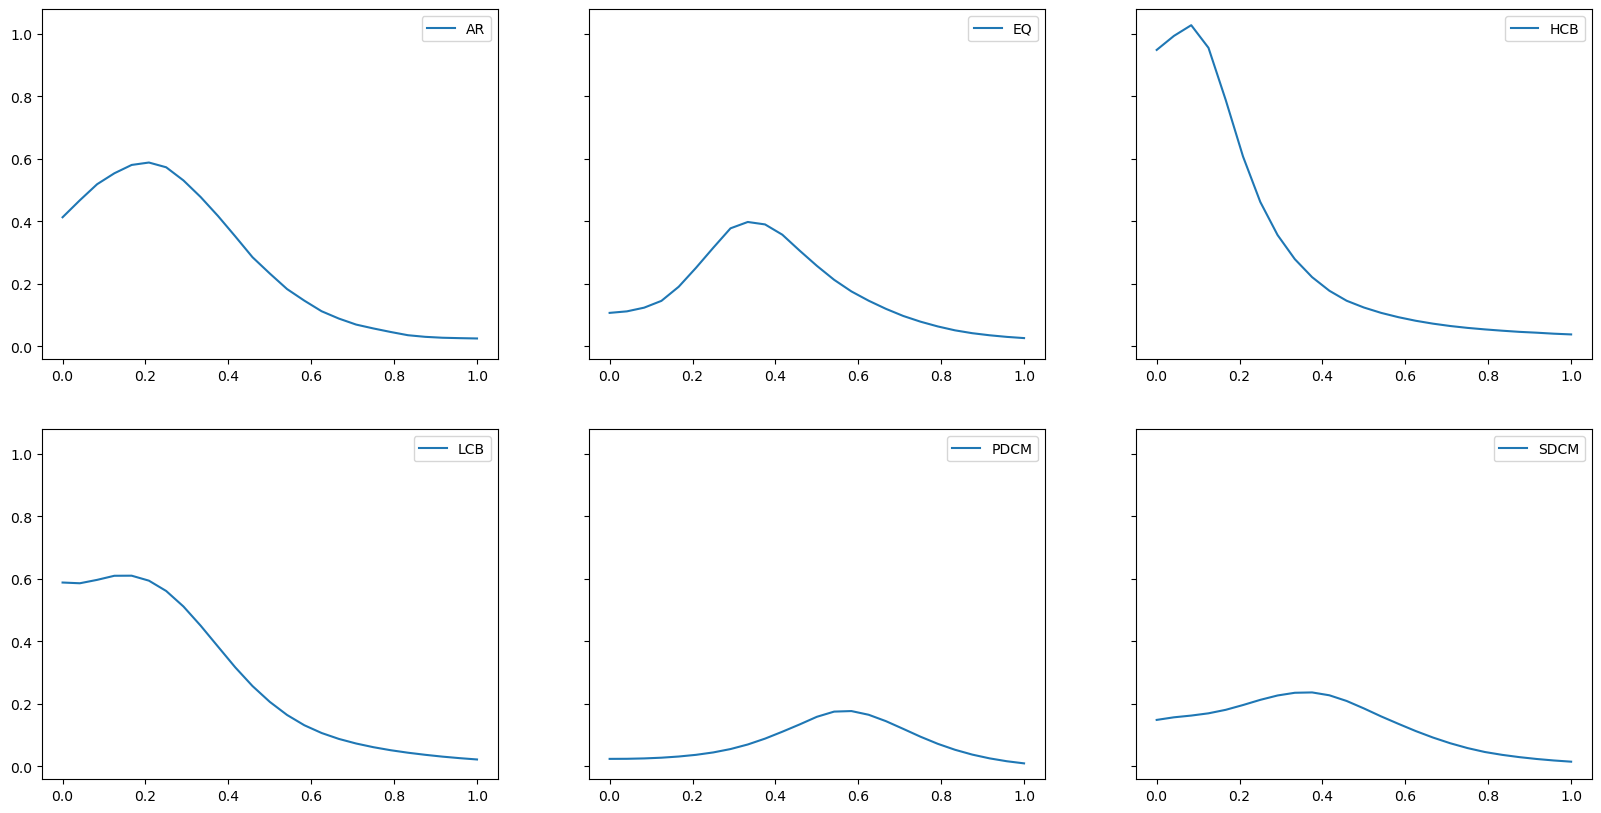

In [71]:
# create our normalized cluster distributions
df_known_dist = pd.read_csv('../data/cluster_chla_distribution.csv')

def build_normalized_cluster_centers(df_known_dist, n_points=25, plot_clusters=False, return_centers=True):
    out = pd.cut(df_known_dist.PRES, bins=25, labels=[i for i in range(25)])
    df_known_dist['depth_bin'] = out
    df_known_dist_binned = df_known_dist[['cluster', 'depth_bin', 'CHLA']] \
        .groupby(['cluster', 'depth_bin']).mean().reset_index().dropna()
    xnew = np.linspace(0, 1, n_points)
    raw_dists = list()
    norm_cluster_depths = {
        'AR': 14,
        'EQ': 18,
        'HCB': 23,
        'LCB': 23,
        'PDCM': 23,
        'SDCM': 20
    }
    if plot_clusters:
        fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
    for i, c in enumerate(np.unique(df_known_dist_binned.cluster)):
        ydata = df_known_dist_binned[df_known_dist_binned.cluster == c]['CHLA'].to_numpy()[:norm_cluster_depths[c]]
        xdata = np.linspace(0, 1, len(ydata))
        fc = interp1d(xdata, ydata, kind='slinear')
        ynew = fc(xnew)
        raw_dists.append(ynew)
        if plot_clusters:
            ax[i // 3, i % 3].plot(xnew, ynew, label=c)
            ax[i //3, i % 3].legend()
    if return_centers:
        return np.array(raw_dists)

print('WOW NORMALIZED CLUSTERS WOOHOO')
centers = build_normalized_cluster_centers(df_known_dist, plot_clusters=True)

In [72]:
# build kmeans for easy cluster prediction
kmeans = KMeans(n_clusters=6)
kmeans.fit(centers)

KMeans(n_clusters=6)

In [73]:
# make prediction interpolations to match the input dimension in our kmeans algorithm
def interpolate_predictions(preds, n_points=25):
    '''
    interpolate our predictions so we can be on the same
    number line as our normalized clusters. this allows us to
    do kmeans predictions to help our predictions!
    '''
    interp_preds = list()
    xold = np.linspace(0, 1, preds.shape[1])
    xnew = np.linspace(0, 1, n_points)
    for p in preds:
        fp = interp1d(xold, p, kind='quadratic')
        pnew = fp(xnew)
        for i, p_l in enumerate(pnew):
            if p_l < p[-1]:
                pnew[i] = p[-1]
        interp_preds.append(pnew)
    return pd.DataFrame(np.array(interp_preds), columns=['intpred_' + str(i) for i in range(n_points)])

interpd_preds = interpolate_predictions(preds)

In [74]:
def mix_vals(x1, x2, perc_x1=0.5):
    perc_x2 = 1-perc_x1
    return (x1*perc_x1) + (x2*perc_x2)

In [75]:
# using our interpolated predictions and closest kmeans cluster
# we can make our final predictions
def build_final_predictions(interpd_preds, kmeans, mixture=0.2, n_points=25):
    kmeans_preds = kmeans.predict(interpd_preds)
    centers = kmeans.cluster_centers_
    final_predictions = list()
    for i, int_p in interpd_preds.iterrows():
        closest_center = centers[kmeans_preds[i], :]
        prediction = mix_vals(closest_center, int_p, perc_x1=mixture)
        final_predictions.append(prediction)
    return pd.DataFrame(np.array(final_predictions), columns=['fin_pred_' + str(i) for i in range(n_points)])

final_predictions = build_final_predictions(interpd_preds, kmeans, mixture=0.08).set_index(full_test.index)

In [76]:
## lets check out our actual distributions
def build_proper_length_distributions(full_test, n_points=25):
    interp_dists = list()
    xnew = np.linspace(0, 1, n_points)
    for i, r in full_test.iterrows():
        depths = r.iloc[10:(10 + r.max_bin)+1].to_numpy()
        xold = np.linspace(0, 1, len(depths))
        fa = interp1d(xold, depths, kind='quadratic')
        interp_dist = fa(xnew)
        for i, f in enumerate(interp_dist):
            if f < depths[-1]:
                interp_dist[i] = depths[-1]
        interp_dists.append(interp_dist)
    return pd.DataFrame(np.array(interp_dists), columns=['int_depth_' + str(i) for i in range(n_points)])

interp_test_dists = build_proper_length_distributions(full_test).set_index(full_test.index)

In [77]:
# now we can check out the mse on the test set
interp_test_dists['cluster'] = full_test['cluster_val']
mixtures = [i / 100 for i in range(11)]
mixture_mse_tot = list()
mixture_mse_perc = list()
for mix in mixtures:
    # create predictions with a given mixture
    final_preds_mix = build_final_predictions(interpd_preds, kmeans, mixture=mix).set_index(full_test.index)
    final_preds_mix['cluster'] = full_test['cluster_val']
    # find total mse
    mse = mean_squared_error(interp_test_dists.to_numpy(), final_preds_mix.to_numpy())
    mixture_mse_tot.append(mse)
    # find mse per cluster
    mixture_mse_perc.append([mean_squared_error(interp_test_dists[interp_test_dists.cluster == i].to_numpy(), final_preds_mix[final_preds_mix.cluster == i].to_numpy()) for i in range(6)] + [mse])

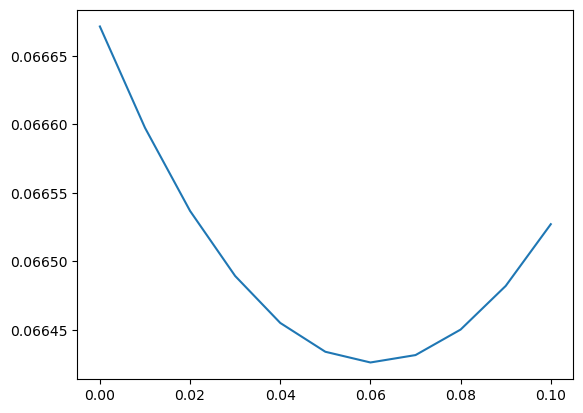

In [78]:
plt.plot(mixtures, mixture_mse_tot)

[]

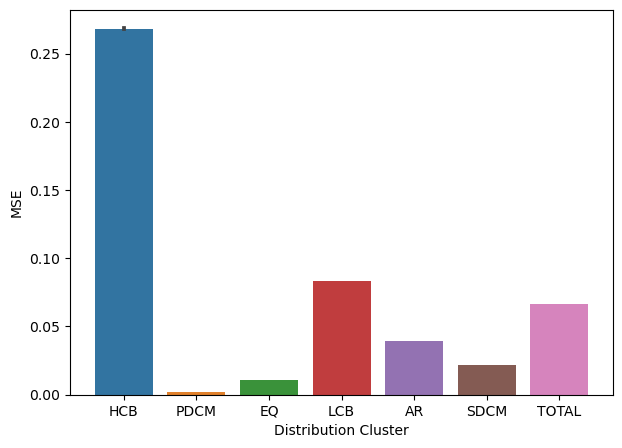

In [79]:
df_mse = pd.DataFrame(mixture_mse_perc, columns=cluster_indeces + ['TOTAL'], index=mixtures)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.barplot(data=df_mse, ax=ax)
ax.set_xlabel('Distribution Cluster')
ax.set_ylabel('MSE')
plt.plot()

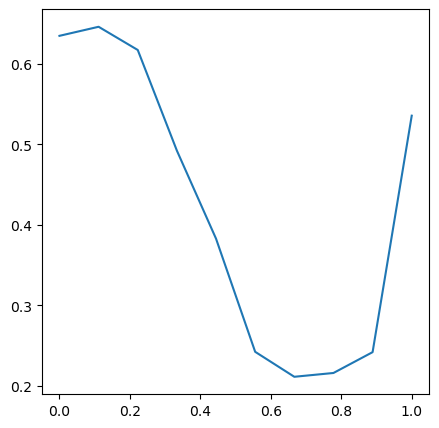

In [80]:
# finally lets check r2 scores on test set
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
depts = [i/9 for i in range(10)]
scores = list()
for i in range(10):
    score = scores.append(r2_score(actuals[:, i], preds[:, i]))
ax.plot(depts, scores)